In [1]:
import pandas as pd
import seaborn as sns
import subprocess as sp

sns.set(color_codes=True)

# Comparación vs test de la catedra
En este experimento obtenemos el error absoluto entre los valores obtenidos por el TP y los esperados por la cátedra utilizando los datos de prueba provistos.

In [2]:
testInFile = '../tests/test_completos/test_completo_100_8.in'
expectedOutFile = '../tests/test_completos/test_completo_100_8.expected'

tpScoreOut = 'test_completo_100_8.out'

sp.call(["../tp", testInFile, tpScoreOut, '0'])

0

In [3]:
expectedScore = pd.read_csv(expectedOutFile, names=['Puntaje'])
tpScore = pd.read_csv(tpScoreOut, names=['Puntaje'])

In [4]:
errorTpVsCatedra = pd.DataFrame({'Equipo': expectedScore.index, 'TP': tpScore['Puntaje'], 'Cátedra': expectedScore['Puntaje'], 'Error': abs(tpScore['Puntaje'] - expectedScore['Puntaje'])})

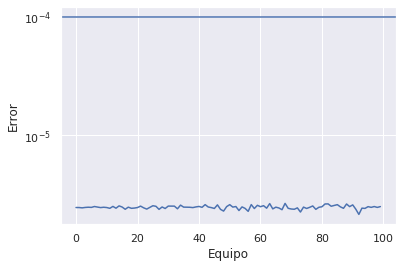

In [5]:
ax = sns.lineplot(x="Equipo", y="Error", data=errorTpVsCatedra)
ax.set_yscale("log")
ax.axhline(0.0001)

In [6]:
errorTpVsCatedra.sort_values(by=['Error'], ascending=False).head(10).style.hide_index()

Equipo,TP,Cátedra,Error
68,0.537182,0.537179,2.66126e-06
63,0.479508,0.479505,2.64935e-06
82,0.449548,0.449545,2.63406e-06
81,0.390938,0.390936,2.6313e-06
88,0.513433,0.51343,2.62891e-06
57,0.497318,0.497316,2.59909e-06
42,0.541767,0.541764,2.59674e-06
50,0.455269,0.455266,2.59604e-06
85,0.457894,0.457892,2.59592e-06
46,0.568494,0.568491,2.58441e-06


# Comparación vs Numpy

En este experimento comparamos el error de los rankings obtenidos utilizando como entradas datos reales de los encuentros ATP, la comparación es entre el puntaje obtenido mediante el TP contra una implementación en numpy

Calculamos el ranking con el TP

In [7]:
import atp2mn
import json

#Entrada Torneos ATP CSV
matchesCSV = '../../data/atp_matches_2018-2019.csv'
#Entrada Datos de los jugadores CSV
playersCSV = '../../data/atp_players.csv'
#Entrada Ranking ATP oficial
rankingCSV = '../../data/atp_rankings_current.csv'

#Salida para tp1
tpFileIn = 'atp_matches_2018-2019.in'
#Salida de metadatos (nombre jugadores, puntaje atp, etc)
metadataFile = 'metadata.json'

atp2mn.parseFromCSV(matchesCSV, playersCSV, rankingCSV, tpFileIn, metadataFile)

tpOutFile = 'atp_matches_2018-2019.out'

sp.call(["../tp", tpFileIn, tpOutFile, '0'])

Done


0

Calculamos el ranking con Numpy

In [8]:
import numpy as np

with open(tpFileIn,'r') as f:
    lines = f.readlines()

header = lines[0].split()
teams = int(header[0])
games = int(header[1])

teamData = {}
for i in range(teams):
    teamData[i] = {}
    teamData[i]["gamesPlayed"] = 0
    teamData[i]["wins"] = 0
    teamData[i]["losses"] = 0
    teamData[i]["playedAgainst"] = [0]*teams

for i in range(games):
    game = lines[i+1].split()
    teamA = int(game[1])-1
    goalsA = int(game[2])
    teamB = int(game[3])-1
    goalsB = int(game[4])

    teamData[teamA]["gamesPlayed"] += 1
    teamData[teamB]["gamesPlayed"] += 1
    if goalsA > goalsB:
        teamData[teamA]["wins"] += 1
        teamData[teamB]["losses"] += 1
    else:
        teamData[teamA]["losses"] += 1
        teamData[teamB]["wins"] += 1

    teamData[teamA]["playedAgainst"][teamB]+=1
    teamData[teamB]["playedAgainst"][teamA]+=1

colley = np.zeros((teams, teams))
b = np.zeros(teams)
for i in teamData:
    for j in range(teams):
        colley[i][j] = -teamData[i]["playedAgainst"][j]
    colley[i][i] = 2 + teamData[i]["gamesPlayed"]
    b[i] = 1+(teamData[i]["wins"]-teamData[i]["losses"])*0.5

numpySolution = np.linalg.solve(colley, b)

In [9]:
with open(metadataFile,'r') as playersJson:
    playersData = json.load(playersJson)

tpScore = pd.read_csv(tpOutFile, names=['Puntaje'])

In [10]:
errorTpVsNumpy = pd.DataFrame({'Equipo': tpScore.index, 'Jugador': [playersData[str(i+1)]['name'] for i in range(len(tpScore))], 'TP': tpScore['Puntaje'], 'Numpy': numpySolution, 'Error': abs(tpScore['Puntaje'] - numpySolution)})

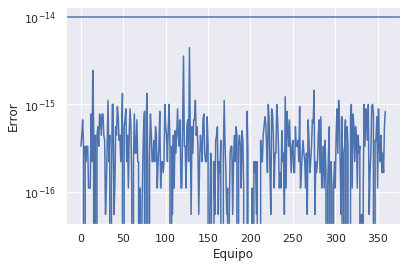

In [11]:
ax = sns.lineplot(x="Equipo", y="Error", data=errorTpVsNumpy)
ax.set_yscale("log")
ax.axhline(1E-14)

In [12]:
errorTpVsNumpy.sort_values(by=['Error'], ascending=False).head(10).style.hide_index()

Equipo,Jugador,TP,Numpy,Error
128,Federer,1.02906,1.02906,4.44089e-15
121,Djokovic,1.08582,1.08582,3.55271e-15
14,Del Potro,1.01672,1.01672,2.44249e-15
275,Brands,0.536975,0.536975,1.44329e-15
49,Gasquet,0.742361,0.742361,1.33227e-15
78,Kicker,0.465702,0.465702,1.33227e-15
241,Ruud,0.639267,0.639267,1.22125e-15
32,Pouille,0.680088,0.680088,1.11022e-15
304,Harris,0.454029,0.454029,1.11022e-15
135,Basic,0.42825,0.42825,1.11022e-15
